# Analysis

In this notebook we'll analyze the data we've extracted before. Our goal here is to get more insights into games that Hikaru played and check if "interesting" streak that GM Kramnik referred to contains any unusual patterns that may lead us to think that Hikaru may be cheating.

To understand some of the stats/data we are working here you have to be familiar with data we extracted and enriched in [data](data.ipynb). 

Here I'll just install some libs that we'll need for future work in this notebook.

In [420]:
!pip install pandas matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'


Load the data we have extracted

In [422]:
with open('./data/enriched/enriched_games_2023.jsonl', 'r') as json_file:
    all_games = [json.loads(line) for line in json_file]

and convert them into pandas data frame

In [423]:
all_games_df = pd.json_normalize(all_games)

Now we will add some more columns that may be useful for our statistic to this dataframe

In [424]:
all_games_df['win'] = all_games_df['hikaru_stats.win'] * 100
all_games_df['timeout_win'] = all_games_df['hikaru_stats.is_timeout_win'] * 100
all_games_df['win1'] = all_games_df['hikaru_stats.was_losing_gte_1_but_won'] * 100
all_games_df['win2'] = all_games_df['hikaru_stats.was_losing_gte_2_but_won'] * 100
all_games_df['win3'] = all_games_df['hikaru_stats.was_losing_gte_3_but_won'] * 100
all_games_df['win4'] = all_games_df['hikaru_stats.was_losing_gte_4_but_won'] * 100
all_games_df['win5'] = all_games_df['hikaru_stats.was_losing_gte_5_but_won'] * 100
all_games_df['hikaru_color'] = all_games_df.apply(lambda row: 'White' if row['white.username'] == "Hikaru"  else 'Black', axis=1)

bins = range(2000, 3500, 100)  # creating rating range buckets
all_games_df['rating_bin'] = pd.cut(all_games_df['hikaru_stats.opponent_rating'], bins=bins)


Let's also create few more DF for some specific subsets of data. The subsets that we will extract are:
<br>
- All blitz games
- Blitz 3 minutes without increment
- Blitz 3 minutes + 1
- "Interesting" streak games
- All blitz games without "interesting" streak games
- All bliz 3 minutes without increment games without "interesting" streak

In [425]:
start_streak_uuid = '5c232585-84b8-11ee-9446-6cfe544c0428'
end_streak_uuid = 'e565825f-858a-11ee-9c40-6cfe544c0428'

all_games_df['main_time_control'] = all_games_df['time_control'].apply(lambda x: int(x.split('+')[0]))
all_games_df['increment'] = all_games_df['time_control'].apply(lambda x: 0 if len(x.split('+')) == 1  else int(x.split('+')[1]))

all_blitz_df = all_games_df.query('main_time_control <= 300')
blitz_180_df = all_blitz_df.query('increment == 0')
blitz_180_plus_1_df = all_blitz_df.query('increment == 1')

streak_start_index = all_games_df.index[all_games_df['uuid'] == start_streak_uuid].tolist()[0]
streak_end_index = all_games_df.index[all_games_df['uuid'] == end_streak_uuid].tolist()[0]

streak_games_df = all_games_df.iloc[streak_start_index:streak_end_index+1]

ids_to_exclude = streak_games_df['uuid'].tolist()

no_streak_games_df = all_games_df[~all_games_df['uuid'].isin(ids_to_exclude)]
all_blitz_no_streak_df = all_blitz_df[~all_blitz_df['uuid'].isin(ids_to_exclude)]
blitz_180_no_streak_df = blitz_180_df[~blitz_180_df['uuid'].isin(ids_to_exclude)]

print(f'All games count {len(all_games_df)}')
print(f'All blitz games count {len(all_blitz_df)}')
print(f'Blitz 3+0 count {len(blitz_180_df)}')
print(f'Blitz 3+1 count {len(blitz_180_plus_1_df)}')
print(f'Streak games count {len(streak_games_df)}')
print(f'All games no streak count {len(no_streak_games_df)}')
print(f'All blitz no streak count {len(all_blitz_no_streak_df)}')
print(f'Blitz 3+0 no streak count {len(blitz_180_no_streak_df)}')


All games count 4891
All blitz games count 4790
Blitz 3+0 count 3815
Blitz 3+1 count 910
Streak games count 44
All games no streak count 4847
All blitz no streak count 4746
Blitz 3+0 no streak count 3771


## On winning

In this section we'll cover some stats on win data. To start off, let see how often does Hikaru win and with what color does that happen more often. As blitz makes majority of Hikarus games, we'll use all_blitz_df from now on to produce stats.

In [426]:
print(all_blitz_df.groupby('hikaru_color').agg(
    {
        'win': 'mean',
        'timeout_win': 'mean'
     }
).to_markdown())

| hikaru_color   |     win |   timeout_win |
|:---------------|--------:|--------------:|
| Black          | 76.4002 |       12.655  |
| White          | 81.6266 |       11.8837 |


What we see above is that Hikaru does have great win percentage in blitz, and it appears to be normally distributed for both piece colors. Also, what we see here is that ~1 out of 10 games Hikaru will win on time. To me that appears to be a really high chance of winning but let's dig deeper to find more on who Hikaru's opponents are.

In [427]:
grouped_by_opponent = all_blitz_df.groupby('hikaru_stats.opponent_username', observed=True)

print(grouped_by_opponent['hikaru_stats.opponent_username'].count().sort_values(ascending=False).head(5).to_markdown())

| hikaru_stats.opponent_username   |   hikaru_stats.opponent_username |
|:---------------------------------|---------------------------------:|
| alexrustemov                     |                              120 |
| artooon                          |                              110 |
| NikoTheodorou                    |                               92 |
| Firouzja2003                     |                               87 |
| 0gZPanda                         |                               86 |


These are 5 players Hikaru played against most. As we can tell he does play often against same players, let's now see their average elo rating.

In [428]:
top_5_opponents = grouped_by_opponent['hikaru_stats.opponent_username'].count().sort_values(ascending=False).head(5).index
top_5_df = all_blitz_df[all_blitz_df['hikaru_stats.opponent_username'].isin(top_5_opponents)]

print(top_5_df.groupby('hikaru_stats.opponent_username').agg({'hikaru_stats.opponent_rating': 'mean'}).loc[top_5_opponents].to_markdown())

| hikaru_stats.opponent_username   |   hikaru_stats.opponent_rating |
|:---------------------------------|-------------------------------:|
| alexrustemov                     |                        2875.34 |
| artooon                          |                        2984.75 |
| NikoTheodorou                    |                        3051.72 |
| Firouzja2003                     |                        3092.66 |
| 0gZPanda                         |                        3001.3  |


We can tell that top two players have quite lower rating than Hikaru while others fluctuate around 3050 which is still significantly lower rating than what Hikaru has (~3200). Now such difference in rating on chess.com does not necessarily mean that Hikaru may win always against these opponents as they themselves are also strong GMs, however it does mean that Hikaru is better and has better experience in using chess.com platform.

Let's now add some other stats on these top 5. Primarily I want to see what is Hikaru win percentage against each of them and percentages on wins on time.

In [429]:
top_5_df['win'] = top_5_df['hikaru_stats.win'] * 100
top_5_df['timeout_win'] = top_5_df['hikaru_stats.is_timeout_win'] * 100

print(top_5_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'hikaru_stats.opponent_rating': 'mean',
        'win': 'mean',
        'timeout_win': 'mean'
     }
).loc[top_5_opponents].to_markdown())


| hikaru_stats.opponent_username   |   hikaru_stats.opponent_rating |     win |   timeout_win |
|:---------------------------------|-------------------------------:|--------:|--------------:|
| alexrustemov                     |                        2875.34 | 85.8333 |      29.1667  |
| artooon                          |                        2984.75 | 74.5455 |       1.81818 |
| NikoTheodorou                    |                        3051.72 | 56.5217 |       9.78261 |
| Firouzja2003                     |                        3092.66 | 41.3793 |       1.14943 |
| 0gZPanda                         |                        3001.3  | 73.2558 |       4.65116 |


We can tell that winning percentage plays well with opponent rating, as higher the opponent rating is less likely it is for Hikaru to win. What surprised me is to see that against alexrustemov Hikaru won almost 30% of games on time. This is surprisingly large number and if anything it tells us that alexrustemov should work on his time management or stop playing Hikaru at all.

On other note Hikaru scored not so well against NikoTheodorou and Firouzja2003, winning just 56% and 41% which, compared to ratings, did result in Hikaru loosing his rating points.


What I want to see now is what is percentage of games that during the game Hikaru was loosing but won anyway. If you remember, in our data extraction we extracted 5 fields where hikaru was loosing by margins of 1,2,3,4,5 but won anyway so lets see this data.

In [430]:
print(top_5_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'hikaru_stats.opponent_rating': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).loc[top_5_opponents].to_markdown())

| hikaru_stats.opponent_username   |   hikaru_stats.opponent_rating |    win1 |    win2 |     win3 |    win4 |    win5 |
|:---------------------------------|-------------------------------:|--------:|--------:|---------:|--------:|--------:|
| alexrustemov                     |                        2875.34 | 45.8333 | 20.8333 | 12.5     | 9.16667 | 3.33333 |
| artooon                          |                        2984.75 | 30      | 14.5455 |  9.09091 | 7.27273 | 7.27273 |
| NikoTheodorou                    |                        3051.72 | 39.1304 | 15.2174 |  8.69565 | 5.43478 | 2.17391 |
| Firouzja2003                     |                        3092.66 | 25.2874 | 13.7931 |  9.1954  | 4.5977  | 3.44828 |
| 0gZPanda                         |                        3001.3  | 40.6977 | 15.1163 |  8.13953 | 6.97674 | 4.65116 |


The above stats also make sense and I don't see anything unusual. Hikaru does have some chance of winning even if he is loosing in position, however as loosing evaluation goes up his chances of winning go down as expected.

Let's now look at entire dataset but first lets split it into rating range buckets.

| rating_bin   |   hikaru_stats.opponent_rating |
|:-------------|-------------------------------:|
| (2000, 2100] |                             24 |
| (2100, 2200] |                             20 |
| (2200, 2300] |                             23 |
| (2300, 2400] |                             36 |
| (2400, 2500] |                             81 |
| (2500, 2600] |                            180 |
| (2600, 2700] |                            256 |
| (2700, 2800] |                            300 |
| (2800, 2900] |                           1045 |
| (2900, 3000] |                           1479 |
| (3000, 3100] |                            869 |
| (3100, 3200] |                            145 |
| (3200, 3300] |                             35 |
| (3300, 3400] |                              2 |


<Figure size 1500x600 with 0 Axes>

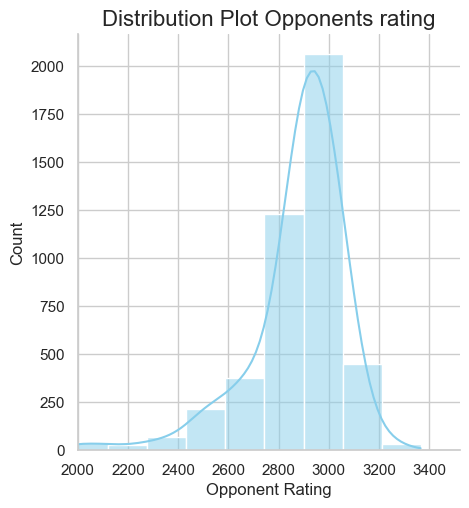

In [431]:
print(all_blitz_df.groupby('rating_bin', observed=True)['hikaru_stats.opponent_rating'].count().to_markdown())

sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
sns.displot(all_blitz_df['hikaru_stats.opponent_rating'], kde=True, bins=20, color='skyblue')

# Title and labels
plt.title('Distribution Plot Opponents rating', fontsize=16)
plt.xlabel('Opponent Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(2000)

# Show the plot
plt.show()

As we can tell Hikaru plays the majority of his games vs opponents that are "much" lower rated than him which can explain Hikaru farming elo rating. In general his opponents rating range is between 2500 - 3200 but by far most games he did play against are in range between 2800 - 3000.

Let's now show some other statistics per rating range.


In [432]:
print(all_blitz_df.groupby('rating_bin', observed=True).agg(
    {
        'win': 'mean',
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).to_markdown())


| rating_bin   |      win |   timeout_win |    win1 |     win2 |     win3 |     win4 |     win5 |
|:-------------|---------:|--------------:|--------:|---------:|---------:|---------:|---------:|
| (2000, 2100] |  91.6667 |       0       | 62.5    | 45.8333  | 33.3333  | 20.8333  | 12.5     |
| (2100, 2200] |  75      |       5       | 50      | 40       | 35       | 20       | 15       |
| (2200, 2300] | 100      |      26.087   | 60.8696 | 34.7826  | 34.7826  | 30.4348  | 17.3913  |
| (2300, 2400] |  83.3333 |      13.8889  | 52.7778 | 33.3333  | 25       | 22.2222  | 16.6667  |
| (2400, 2500] |  98.7654 |      16.0494  | 50.6173 | 23.4568  | 19.7531  | 16.0494  | 13.5802  |
| (2500, 2600] |  93.3333 |      18.3333  | 55      | 28.3333  | 16.1111  | 11.6667  | 10       |
| (2600, 2700] |  94.5312 |      16.4062  | 50.3906 | 26.1719  | 16.4062  | 12.1094  | 10.1562  |
| (2700, 2800] |  93.6667 |      14       | 46.3333 | 23.6667  | 16       | 12.6667  |  8.33333 |
| (2800, 2900] |  88

Stats per rating range do seem to be as expected. In general, as Hikaru's opponent rating range increases he does have lower chance of winning. Same apply for stats where hikaru was loosing but won at the end, as the higher opponent elo is it is harder for Hikaru to make comeback from loosing position. 

Let's now see these stats for the streak games and see if they deviate from what we saw so far. We'll also take a subset from above table which is relevant for streak games.

In [433]:
print(all_blitz_df.groupby('rating_bin', observed=True).agg(
    {
        'win': 'mean',
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).iloc[9:11, :].to_markdown())
print("\n")
print(streak_games_df.groupby('rating_bin', observed=True).agg(
    {
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).to_markdown(headers=['Opponent elo', 'Win count', 'Win avg %', 'Timeout win avg %', 'win1', 'win2', 'win3', 'win4', 'win5']))

| rating_bin   |     win |   timeout_win |    win1 |    win2 |    win3 |    win4 |    win5 |
|:-------------|--------:|--------------:|--------:|--------:|--------:|--------:|--------:|
| (2900, 3000] | 78.3638 |       12.1704 | 39.6214 | 19.2698 | 12.7113 | 8.92495 | 5.94997 |
| (3000, 3100] | 58.6881 |       10.4718 | 32.7963 | 16.5708 | 10.9321 | 8.28539 | 5.63867 |


| Opponent elo   |   Win count |   Win avg % |   Timeout win avg % |    win1 |    win2 |    win3 |    win4 |    win5 |
|:---------------|------------:|------------:|--------------------:|--------:|--------:|--------:|--------:|--------:|
| (2900, 3000]   |          38 |     97.3684 |             18.4211 | 47.3684 | 21.0526 | 18.4211 | 13.1579 | 7.89474 |
| (3000, 3100]   |           6 |    100      |             16.6667 | 50      | 33.3333 | 16.6667 | 16.6667 | 0       |


Here we can see that streak games do have slightly higher numbers compared to overall dataset. However, as we cherry-picked specific winning streak such differences do not seem to be significant.

Overall winning data did not show me anything "interesting". GM Hikaru is usually playing lower rated players, and he does win a lot. When playing such players he does have less stress as he can more easily make comeback from worst position. Against higher rated players Hikaru would have much lower chances on making such streak as he does win much less and have fewer chances to recover from worst position.

Let's now move to analyze moves data within these games.

## On moves

Here we will examine moves statistic and compare in with other data in our datasets. More specifically we want to see how many good moves Hikaru plays under which condition and how does that affect his winning chances. If you remember, during our data extraction we did extract some stats on move classification which ranges from Excellent - Blunder, however we also did add stats on a column which represent whether the specific move was one of the top 2 moves offered by stockfish.

Let's start by plotting distribution of top 2 moves percentage accross games.

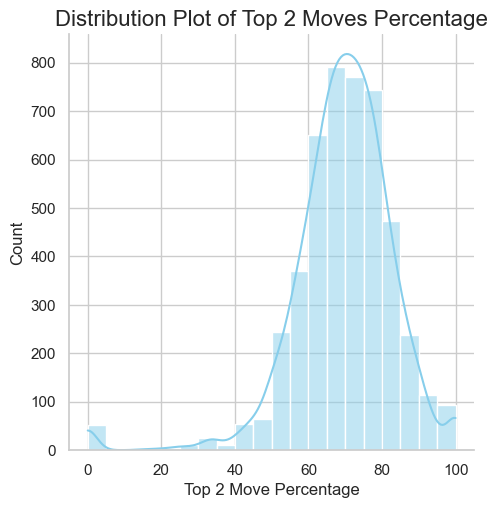

In [434]:
sns.displot(all_blitz_df['hikaru_stats.top_2_move_perc'], kde=True, bins=20, color='skyblue')

plt.title('Distribution Plot of Top 2 Moves Percentage', fontsize=16)
plt.xlabel('Top 2 Move Percentage', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

We can tell that data is normally distributed and that majority of games did have top 2 moves percentage between 60% and 80%. What this means is that in majority of the games Hikaru did play one of the top two moves offered by stockfish for 60-80% of a time. 

Let's now see how best move percentage is fluctuating when we plot it per elo rating range. For this exercise we'll be plotting 3 datasets:

-   All blitz games without streak games
-   3 minutes no increment games without streak games
-   Streak games

We want to see if there is significant difference in streak games when compared to other blitz games for rating range.

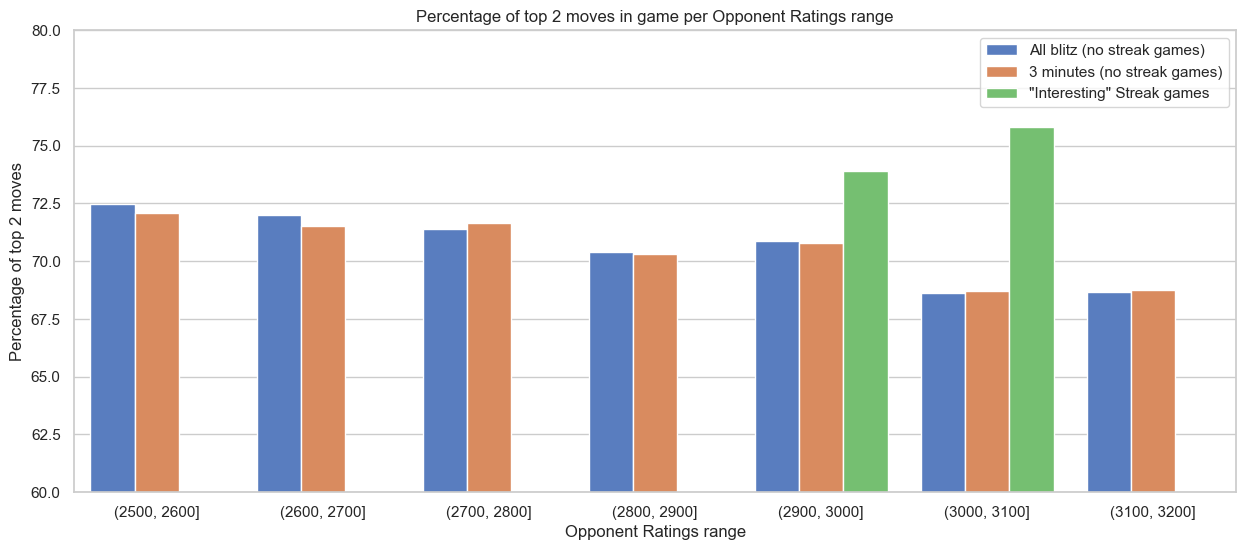

In [435]:
average_percentage_streak_games = streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()
average_percentage_all_blitz_no_streak = all_blitz_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()
average_percentage_blitz_180_no_streak = blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()

plt.figure(figsize=(15, 6))

combined_df = pd.concat([average_percentage_all_blitz_no_streak, average_percentage_blitz_180_no_streak, average_percentage_streak_games], keys=['All blitz (no streak games)', '3 minutes (no streak games)', '"Interesting" Streak games'], names=['DataFrame']).reset_index()

sns.barplot(x='rating_bin', y='hikaru_stats.top_2_move_perc', hue='DataFrame', data=combined_df, palette='muted')

plt.title('Percentage of top 2 moves in game per Opponent Ratings range')
plt.xlabel('Opponent Ratings range')
plt.ylabel('Percentage of top 2 moves')
plt.axis([4.5, 11.5, 60, 80])
plt.legend()
plt.show()

Here we can tell that there is a difference in percentage of top 2 moves per game when we compare streak games vs blitz games. For elo rating range 2900 - 3000 difference is about 3% and for elo rating range 3000 - 3100 is about 7%. We can also see that majority of streak games are played for 2900 - 3000 elo rating range and only 6 games where Hikaru players were in elo range of 3000 - 3100. However, these percentage still fall into range of 60% - 80%.

We can also see that as the opponents rating elo increases best moves percentage of Hikaru slightly decreases.


In [436]:
bucket_one_diff = average_percentage_streak_games['hikaru_stats.top_2_move_perc'][0] - average_percentage_blitz_180_no_streak['hikaru_stats.top_2_move_perc'][9]
bucket_two_diff = average_percentage_streak_games['hikaru_stats.top_2_move_perc'][1] - average_percentage_blitz_180_no_streak['hikaru_stats.top_2_move_perc'][10]

print(f'Difference for elo rating range 2900 - 3000 is {bucket_one_diff}')
print(f'Difference for elo rating range 3000 - 3100 is {bucket_two_diff}')
print(streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].count().to_markdown())

Difference for elo rating range 2900 - 3000 is 3.141526095607091
Difference for elo rating range 3000 - 3100 is 7.105888335739479
| rating_bin   |   hikaru_stats.top_2_move_perc |
|:-------------|-------------------------------:|
| (2900, 3000] |                             38 |
| (3000, 3100] |                              6 |


Let's also see average thinking time per these moves.

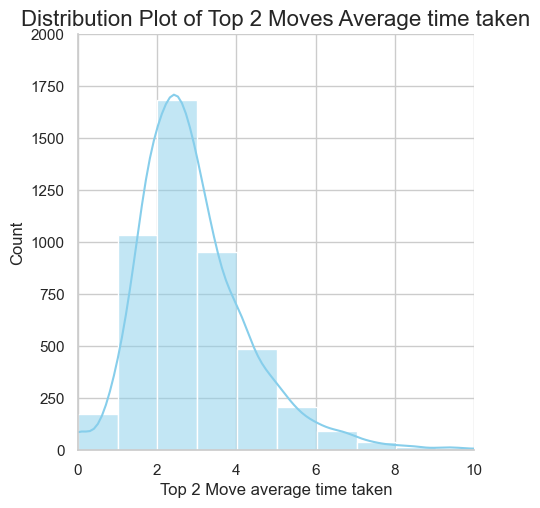

In [437]:
sns.displot(all_blitz_df['hikaru_stats.top_2_move_avg'], kde=True, bins=20, color='skyblue')

plt.title('Distribution Plot of Top 2 Moves Average time taken', fontsize=16)
plt.xlabel('Top 2 Move average time taken', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axis([0, 10, 0, 2000])

plt.show()

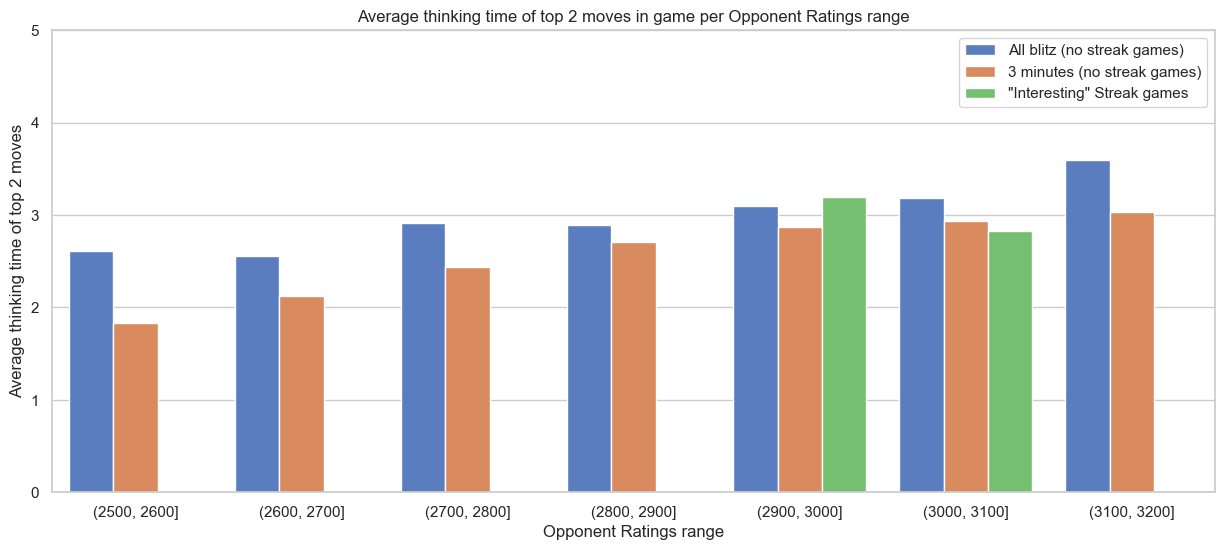

In [438]:
average_time_streak_games = streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_avg'].mean().reset_index()
average_time_all_blitz_no_streak = all_blitz_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_avg'].mean().reset_index()
average_time_blitz_180_no_streak = blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_avg'].mean().reset_index()

plt.figure(figsize=(15, 6))

combined_df = pd.concat([average_time_all_blitz_no_streak, average_time_blitz_180_no_streak, average_time_streak_games], keys=['All blitz (no streak games)', '3 minutes (no streak games)', '"Interesting" Streak games'], names=['DataFrame']).reset_index()

sns.barplot(x='rating_bin', y='hikaru_stats.top_2_move_avg', hue='DataFrame', data=combined_df, palette='muted')

plt.title('Average thinking time of top 2 moves in game per Opponent Ratings range')
plt.xlabel('Opponent Ratings range')
plt.ylabel('Average thinking time of top 2 moves')
plt.axis([4.5, 11.5, 0, 5])
plt.legend()
plt.show()

Similarly to percentage of top two moves there is no significant difference comparing streak games to other blitz games. In general as opponent rating increases so does Hikaru's thinking time.

Let's now see distribution of different move classifications per opponent elo rating bucket. Previously in data notebook we have extracted these move classifications, and now we will plot their percentage and average thinking time.

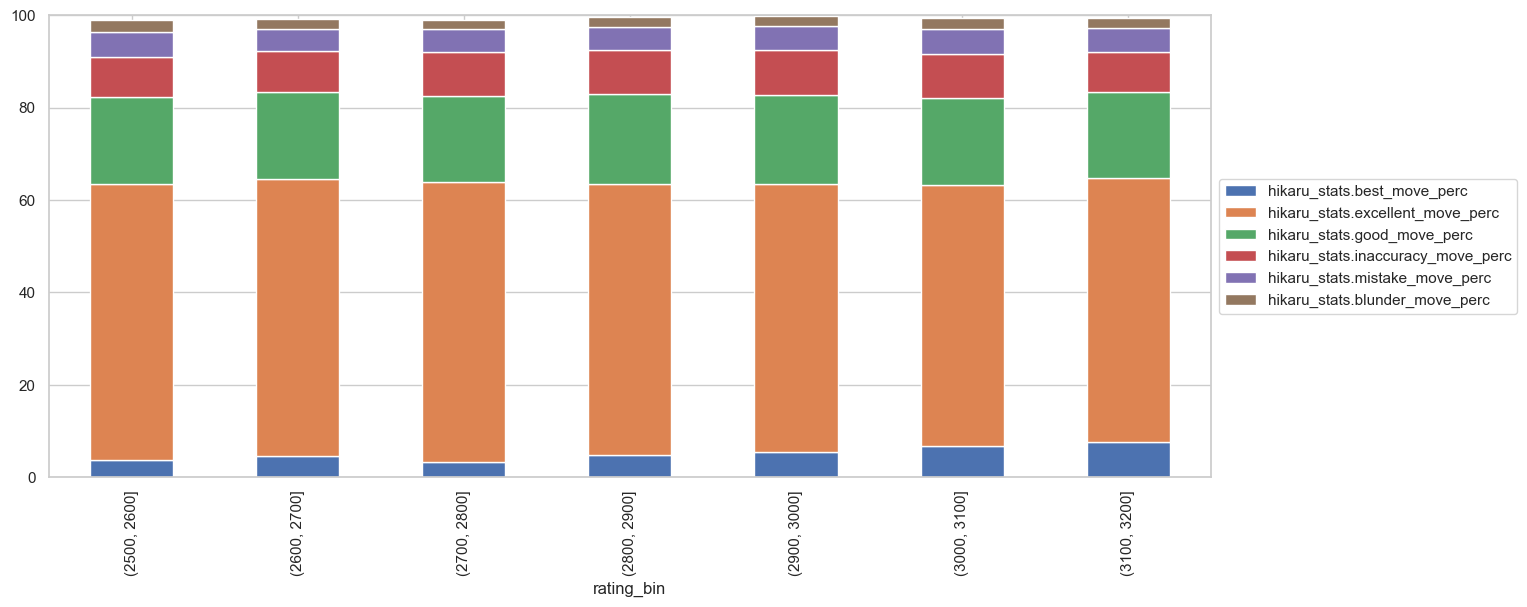

In [439]:
columns_to_stack = ['hikaru_stats.excellent_move_perc', 'hikaru_stats.best_move_perc', 'hikaru_stats.good_move_perc', 'hikaru_stats.inaccuracy_move_perc', 'hikaru_stats.mistake_move_perc', 'hikaru_stats.blunder_move_perc']

streak_games_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_perc': 'mean',
    'hikaru_stats.excellent_move_perc': 'mean',
    'hikaru_stats.good_move_perc': 'mean',
    'hikaru_stats.inaccuracy_move_perc': 'mean',
    'hikaru_stats.mistake_move_perc': 'mean',
    'hikaru_stats.blunder_move_perc': 'mean'
}).reset_index()

all_blitz_no_streak_classification_df = all_blitz_no_streak_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_perc': 'mean',
    'hikaru_stats.excellent_move_perc': 'mean',
    'hikaru_stats.good_move_perc': 'mean',
    'hikaru_stats.inaccuracy_move_perc': 'mean',
    'hikaru_stats.mistake_move_perc': 'mean',
    'hikaru_stats.blunder_move_perc': 'mean'
}).reset_index()


df_plt = all_blitz_no_streak_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 100])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

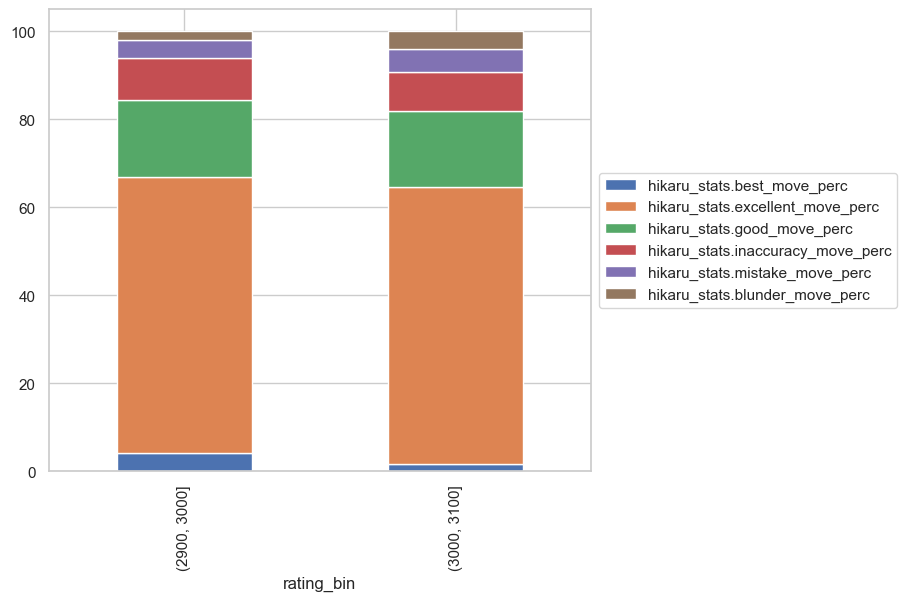

In [440]:
df_plt = streak_games_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can tell that, as for the top 2 moves percentage, Hikaru does make good moves >80% of the time which is expected given his expertize. To be honest, I was expecting this number to be even >90%. We can also tell that "interesting" streak games do not deviate from his non streak games, if anything he makes less Best moves which is the best possible option. Let's see these numbers in table

In [441]:
numerical_columns = all_blitz_no_streak_classification_df.select_dtypes(include='number').columns
all_blitz_no_streak_classification_subset_df = all_blitz_no_streak_classification_df.iloc[9:11, :].reset_index(drop=True)
numerical_difference = streak_games_classification_df[numerical_columns] - all_blitz_no_streak_classification_subset_df[numerical_columns]


print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -1.43065 |               4.75049 |         -1.64963 |             -0.0915996 |          -1.22119   |           -0.149227 |
|  1 |         -5.15101 |               6.50406 |         -1.49145 |             -0.843023  |          -0.0883487 |            1.64913  |


So in "interesting" streak games hikaru did make less "Best" moves for 1.4% and more excellent moves for 4.7%. If we compare this to top 2 moves percentage statistic we did before what it actually means is that Hikaru in his "interesting" streak games did make less first choice stockfish moves but more second choice stockfish moves. Also, in general, Hikaru did make less bad moves compared to his other blitz games.

Second row in this table is for range 3000 - 3100 elo range but only for 6 games played therefore not a lot of meaningful analytics can be taken out of it.

So far we saw on how Hikaru played these "interesting" streak games, but let's see how his opponents did play. We'll gather same stats we did for Hikaru for his opponents and what we are interested in is to see if his opponents during streak games did make more bad moves compared to in general opponents.

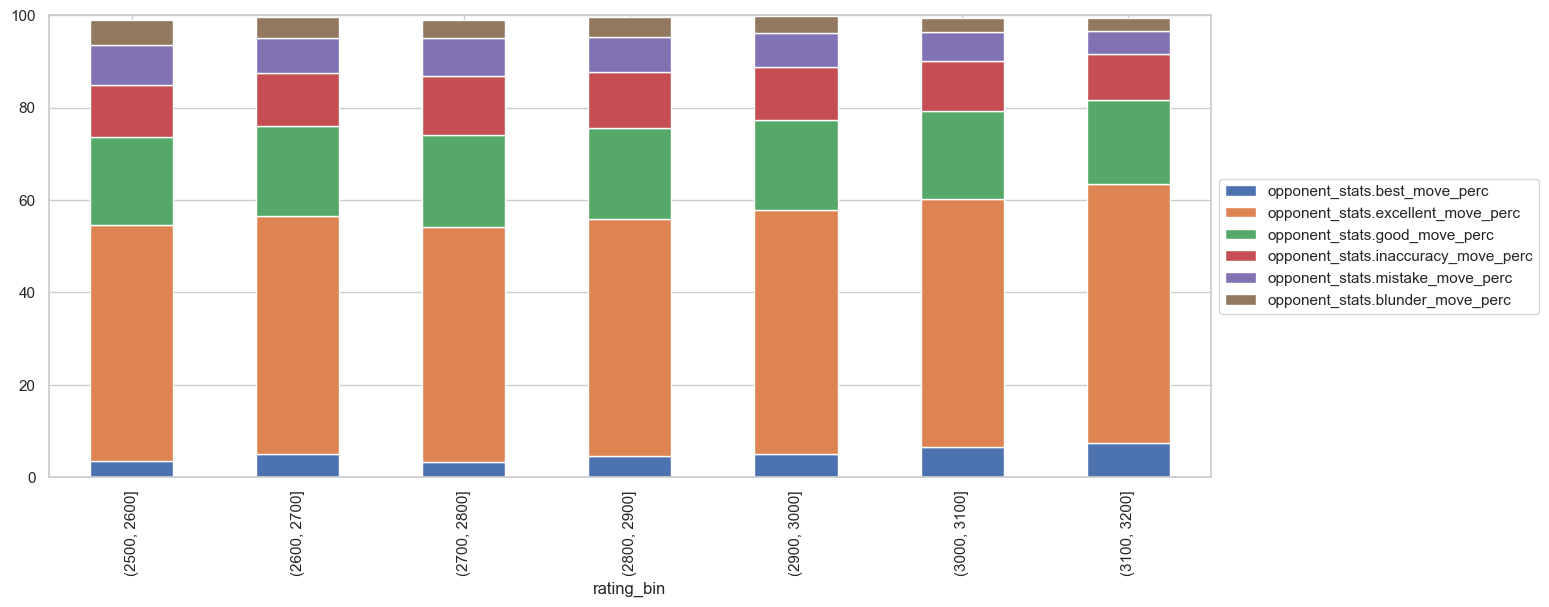

In [442]:
opponent_streak_games_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'opponent_stats.best_move_perc': 'mean',
    'opponent_stats.excellent_move_perc': 'mean',
    'opponent_stats.good_move_perc': 'mean',
    'opponent_stats.inaccuracy_move_perc': 'mean',
    'opponent_stats.mistake_move_perc': 'mean',
    'opponent_stats.blunder_move_perc': 'mean'
}).reset_index()

opponent_all_blitz_no_streak_classification_df = all_blitz_no_streak_df.groupby('rating_bin', observed=True).agg({
    'opponent_stats.best_move_perc': 'mean',
    'opponent_stats.excellent_move_perc': 'mean',
    'opponent_stats.good_move_perc': 'mean',
    'opponent_stats.inaccuracy_move_perc': 'mean',
    'opponent_stats.mistake_move_perc': 'mean',
    'opponent_stats.blunder_move_perc': 'mean'
}).reset_index()


df_plt = opponent_all_blitz_no_streak_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 100])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

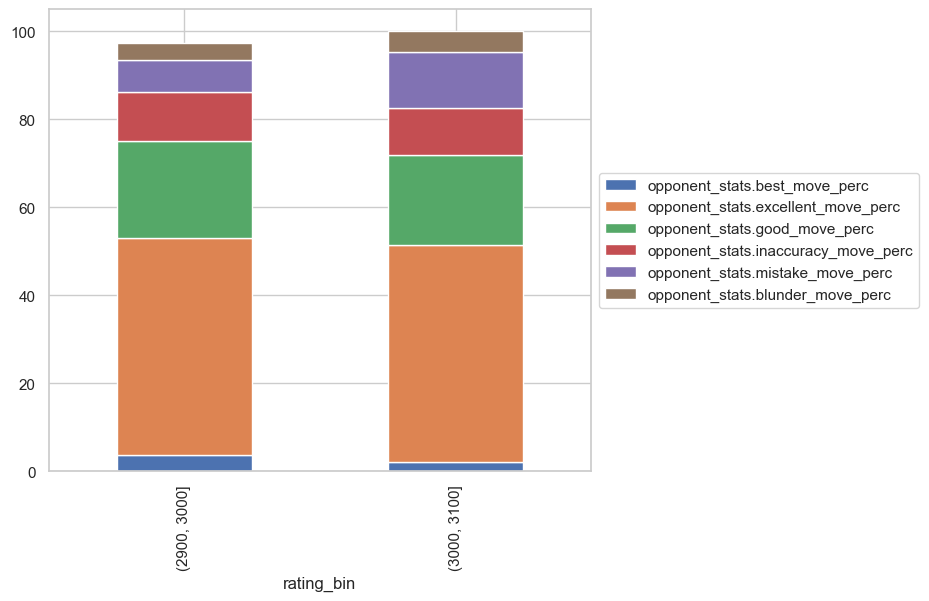

In [443]:
opponent_df_plt = opponent_streak_games_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
opponent_df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [444]:
opponent_numerical_columns = opponent_all_blitz_no_streak_classification_df.select_dtypes(include='number').columns
opponent_all_blitz_no_streak_classification_subset_df = opponent_all_blitz_no_streak_classification_df.iloc[9:11, :].reset_index(drop=True)
opponent_numerical_difference = opponent_streak_games_classification_df[opponent_numerical_columns] - opponent_all_blitz_no_streak_classification_subset_df[opponent_numerical_columns]


print(opponent_numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -1.41688 |              -3.46282 |          2.59109 |              -0.525887 |            0.317357 |           0.0737531 |
|  1 |         -4.51317 |              -4.30728 |          1.24762 |               0.141864 |            6.53126  |           1.47908   |


As expected, we can see that Hikaru's opponents in "interesting" streak games did make less good moves and a slightly more bad moves. In good moves category, they did more good moves which leads to evaluation loss in between 0.02 - 0.05 and did much less excellent and best moves which give better chances in game and leads to better situation. In bad moves category, they did less inaccurate moves (which is the best category in bad) and did a slightly more mistake and blunder moves.

In general all of this seems to align with what GM Hikaru Nakamura is saying about cherry-picking his opponents. Apparently these opponents do play slightly worse then the rest of the opponents Hikaru played against in same rating bucket and Hikaru is able to play better against them compared to the others. 

Let's go back to Hikaru's stats and see average thinking time per move classification.

|    | Opponent range   |   Best Move Avg |   Excellent Move Avg |   Good Move Avg |   Inaccuracy Move Avg |   Mistake Move Avg |   Blunder Move Avg |
|---:|:-----------------|----------------:|---------------------:|----------------:|----------------------:|-------------------:|-------------------:|
|  5 | (2500, 2600]     |        0.751109 |              2.53053 |         2.93655 |               3.22539 |            3.21064 |            1.89456 |
|  6 | (2600, 2700]     |        0.86521  |              2.54609 |         3.18999 |               3.60296 |            3.48538 |            2.20201 |
|  7 | (2700, 2800]     |        0.917888 |              2.83557 |         3.82581 |               4.1832  |            3.21059 |            1.90563 |
|  8 | (2800, 2900]     |        0.985398 |              2.81064 |         3.67503 |               3.94164 |            3.67248 |            2.00195 |
|  9 | (2900, 3000]     |        1.16577  |              3.00601 |         4.02047 |          

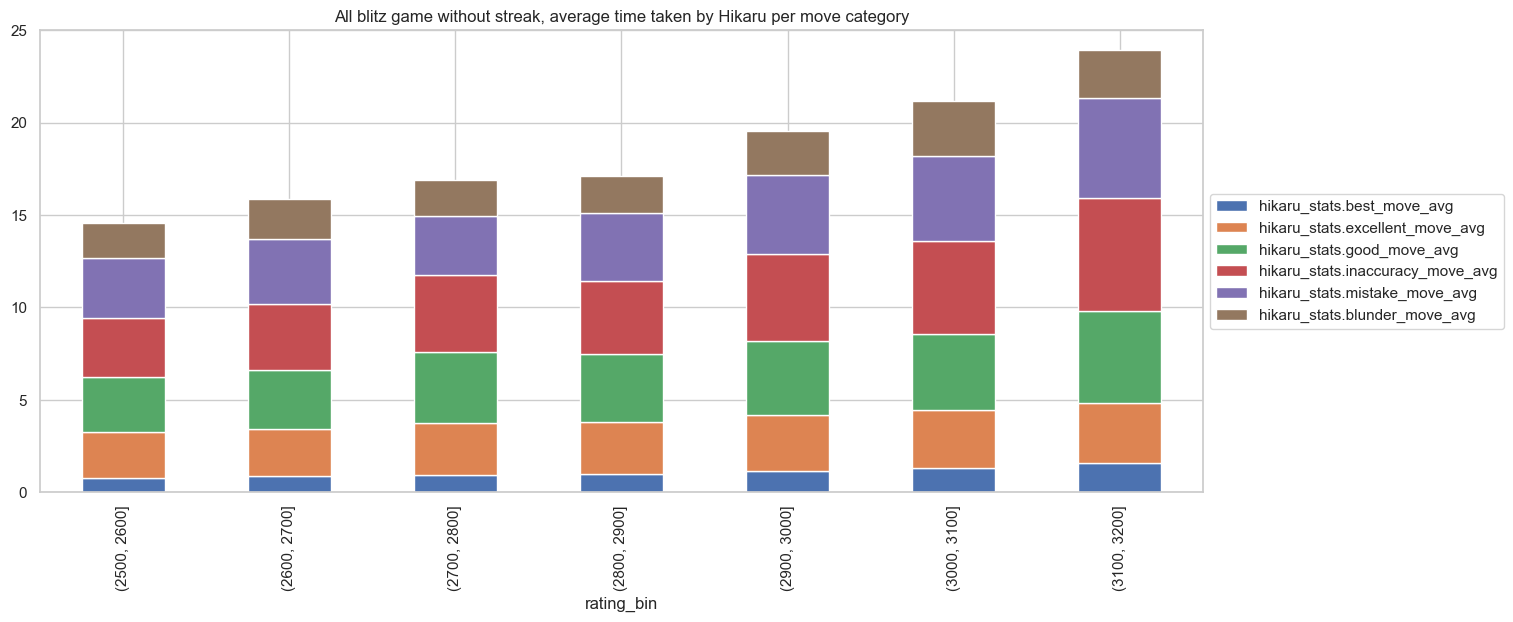

In [445]:
streak_games_time_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_avg': 'mean',
    'hikaru_stats.excellent_move_avg': 'mean',
    'hikaru_stats.good_move_avg': 'mean',
    'hikaru_stats.inaccuracy_move_avg': 'mean',
    'hikaru_stats.mistake_move_avg': 'mean',
    'hikaru_stats.blunder_move_avg': 'mean'
}).reset_index()

all_blitz_no_streak_time_classification_df = all_blitz_no_streak_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_avg': 'mean',
    'hikaru_stats.excellent_move_avg': 'mean',
    'hikaru_stats.good_move_avg': 'mean',
    'hikaru_stats.inaccuracy_move_avg': 'mean',
    'hikaru_stats.mistake_move_avg': 'mean',
    'hikaru_stats.blunder_move_avg': 'mean'
}).reset_index()

df_plt = all_blitz_no_streak_time_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 25])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_plt.set_title('All blitz game without streak, average time taken by Hikaru per move category')

print(all_blitz_no_streak_time_classification_df.iloc[5:12, :].to_markdown(headers=['Opponent range', 'Best Move Avg', 'Excellent Move Avg', 'Good Move Avg', 'Inaccuracy Move Avg', 'Mistake Move Avg', 'Blunder Move Avg']))

From above, we can see that Hikaru spends more time thinking and playing bad moves compared to good moves. Let's now compare these stats to "interesting" streak games and see if there is any difference in taking good/bad moves in these games compared to all blitz games.

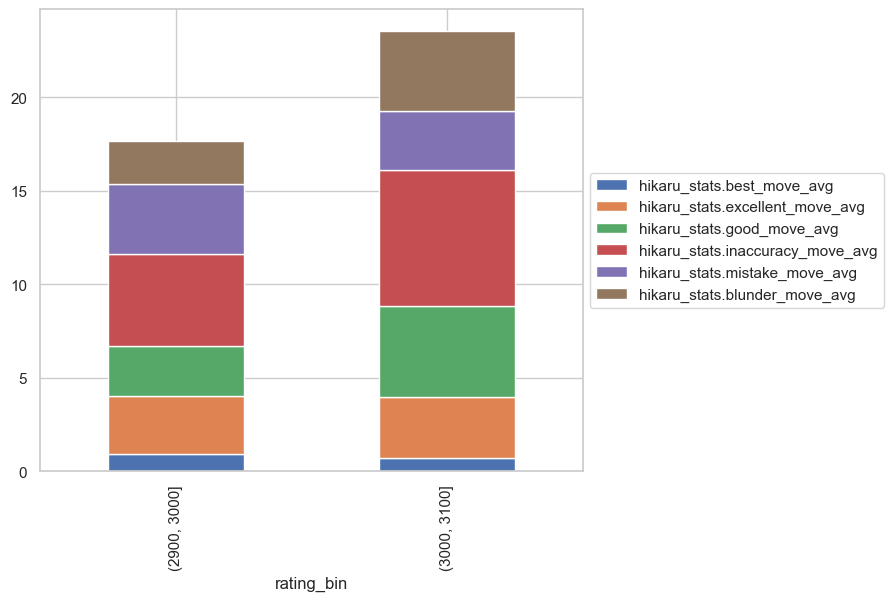

In [446]:
df_plt = streak_games_time_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [447]:
numerical_columns = all_blitz_no_streak_time_classification_df.select_dtypes(include='number').columns
all_blitz_no_streak_time_classification_subset_df = all_blitz_no_streak_time_classification_df.iloc[9:11, :].reset_index(drop=True)
numerical_difference = streak_games_time_classification_df[numerical_columns] - all_blitz_no_streak_time_classification_subset_df[numerical_columns]


print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |        -0.241188 |              0.109945 |        -1.37133  |                0.25325 |           -0.543993 |           -0.120168 |
|  1 |        -0.607794 |              0.155484 |         0.725744 |                2.2248  |           -1.40562  |            1.25048  |


These numbers do not deviate a lot from 0 and given they're in seconds I do not see anything "interesting" in average time taken by move. 
<br>

So far we looked at overall games statistic. Remember that we also gathered these as per game phase, so we can see differences between endgame and middlegame stats.

In [453]:
for phase in ['middlegame', 'endgame']:
    
    streak_games_phase_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
        f'hikaru_stats.best_{phase}_move_perc': 'mean',
        f'hikaru_stats.excellent_{phase}_move_perc': 'mean',
        f'hikaru_stats.good_{phase}_move_perc': 'mean',
        f'hikaru_stats.inaccuracy_{phase}_move_perc': 'mean',
        f'hikaru_stats.mistake_{phase}_move_perc': 'mean',
        f'hikaru_stats.blunder_{phase}_move_perc': 'mean'
    }).reset_index()
    
    
    all_blitz_no_streak_phase_classification_df = all_blitz_no_streak_df.groupby('rating_bin', observed=True).agg({
        f'hikaru_stats.best_{phase}_move_perc': 'mean',
        f'hikaru_stats.excellent_{phase}_move_perc': 'mean',
        f'hikaru_stats.good_{phase}_move_perc': 'mean',
        f'hikaru_stats.inaccuracy_{phase}_move_perc': 'mean',
        f'hikaru_stats.mistake_{phase}_move_perc': 'mean',
        f'hikaru_stats.blunder_{phase}_move_perc': 'mean'
    }).reset_index()
    
    
    numerical_columns = all_blitz_no_streak_phase_classification_df.select_dtypes(include='number').columns
    all_blitz_no_streak_phase_classification_subset_df = all_blitz_no_streak_phase_classification_df.iloc[9:11, :].reset_index(drop=True)
    numerical_difference = streak_games_phase_classification_df[numerical_columns] - all_blitz_no_streak_phase_classification_subset_df[numerical_columns]
    
    print(f'Differences in move classification percentage for phase {phase}')
    print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))
    print('\n')

Differences in move classification percentage for phase middlegame
|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |        -0.279798 |               2.90825 |         -1.21536 |              -0.104416 |          -1.03421   |          -0.0662793 |
|  1 |        -1.65229  |               3.49921 |         -2.91478 |              -0.86951  |          -0.0468146 |           2.56356   |


Differences in move classification percentage for phase endgame
|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -2.77957 |             -

Middlegame stats seems to be inline with what we saw overall as Hikaru does make a bit more excellent moves and a bit less of other moves. However, for endgame and specifically for elo rating 3000 - 3100 Hikaru did make 20% more excellent moves in streak compared to all blitz games. This may be interesting, however let's remember that 3000 - 3100 count for only 6 games so lets now see how many excellent endgame moves there was.

In [454]:
print(streak_games_df.groupby('rating_bin', observed=True).agg({
    f'hikaru_stats.excellent_endgame_move_count': 'sum',
}))

              hikaru_stats.excellent_endgame_move_count
rating_bin                                             
(2900, 3000]                                      305.0
(3000, 3100]                                       33.0


As there was 33 excellent engame moves over 6 games in this bucket it is not enough to draw any conclusion as sample size is too small to compare with all blitz games.

Next I want to focus on checking how good/bad moves percentage and timing correlate with information whether Hikaru was loosing by margin (1-5) but winning anyway.

TO BE CONTINUED...

### Bonus

As Hikaru claims that he is farming elo by cherry-picking opponents, let's put a table with these stats of all opponents who Hikaru played against at least 20 times. This may give Hikaru better insight on which opponents he wants to play when farming elo rating. You can find output file under [file](data/analysis/bonus_stats.csv).

This section is not part of analysis, it's just for fun. 

In [491]:
all_opponents = all_blitz_df.groupby('hikaru_stats.opponent_username').size().reset_index(name='Count')
opponents_more_then_20_games = all_opponents[all_opponents['Count'] > 20]
print(len(opponents_more_then_20_games))

filtered_by_20_games_df = all_blitz_df[all_blitz_df['hikaru_stats.opponent_username'].isin(opponents_more_then_20_games['hikaru_stats.opponent_username'])]

def first_occurrence(value_series):
    return value_series.iloc[0]

stats_df = filtered_by_20_games_df.groupby('hikaru_stats.opponent_username', observed=True).agg(
    {
        'hikaru_stats.opponent_username': first_occurrence,
        'hikaru_stats.opponent_rating': 'mean',
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
        'hikaru_stats.top_2_move_perc': 'mean',
        'hikaru_stats.best_move_perc': 'mean',
        'hikaru_stats.excellent_move_perc': 'mean',
        'hikaru_stats.good_move_perc': 'mean',
        'hikaru_stats.inaccuracy_move_perc': 'mean',
        'hikaru_stats.mistake_move_perc': 'mean',
        'hikaru_stats.blunder_move_perc': 'mean',
        'hikaru_stats.top_2_move_avg': 'mean',
        'hikaru_stats.best_move_avg': 'mean',
        'hikaru_stats.excellent_move_avg': 'mean',
        'hikaru_stats.good_move_avg': 'mean',
        'hikaru_stats.inaccuracy_move_avg': 'mean',
        'hikaru_stats.mistake_move_avg': 'mean',
        'hikaru_stats.blunder_move_avg': 'mean',
        'opponent_stats.top_2_move_perc': 'mean',
        'opponent_stats.best_move_perc': 'mean',
        'opponent_stats.excellent_move_perc': 'mean',
        'opponent_stats.good_move_perc': 'mean',
        'opponent_stats.inaccuracy_move_perc': 'mean',
        'opponent_stats.mistake_move_perc': 'mean',
        'opponent_stats.blunder_move_perc': 'mean'
     }
)

stats_df.to_csv('data/analysis/bonus_stats.csv', index=False, header=[
    'Opponent',
    'Opponent Elo',
    'Played count',
    'Win avg %',
    'Timeout win avg %',
    'Was loosing by >=1 but won',
    'Was loosing by >=2 but won',
    'Was loosing by >=3 but won',
    'Was loosing by >=4 but won',
    'Was loosing by >=5 but won',
    'Hikaru Top 2 Moves %',
    'Hikaru Best Move %',
    'Hikaru Excellent Move %',
    'Hikaru Good Move %',
    'Hikaru Inaccuracy Move %',
    'Hikaru Mistake Move %',
    'Hikaru Blunder Move %',
    'Hikaru Top 2 Moves Time Taken Avg',
    'Hikaru Best Move Time Taken Avg',
    'Hikaru Excellent Move Time Taken Avg',
    'Hikaru Good Move Time Taken Avg',
    'Hikaru Inaccuracy Move Time Taken Avg',
    'Hikaru Mistake Move Time Taken Avg',
    'Hikaru Blunder Move Time Taken Avg',
    'Opponent Top 2 Moves %',
    'Opponent Best Move %',
    'Opponent Excellent Move %',
    'Opponent Good Move %',
    'Opponent Inaccuracy Move %',
    'Opponent Mistake Move %',
    'Opponent Blunder Move %',
])


56


## P-value
TBD
## Bayes
TBD